In [39]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [40]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [41]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [42]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [43]:
# reflect an existing database into a new model ADDED
Base = automap_base()

# reflect the tables ADDED
Base.prepare(engine, reflect=True)

In [44]:
# View all of the classes that automap found added
Base.classes.keys()

['measurement', 'station']

In [45]:
# Save references to each table added
Measurement = Base.classes.measurement
Station = Base.classes.station

In [46]:
# Create our session (link) from Python to the DB added
session = Session(engine)

# Exploratory Precipitation Analysis

In [55]:
# Get a list of column names and types to identify columns
# columns = inspector.get_columns('measurement')
# for c in columns:
#     print(c['name'], c["type"])

In [49]:
#sanity check to see where the last date is located.
# measurement_query = session.query(Measurement)
# for row in measurement_query:
#     print(f"{row.date}, {row.prcp}")

In [50]:
# Find the most recent date in the data set. But I realize this is in a form of row.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# to put into calculation.
last_date = session.query(func.max(Measurement.date)).scalar()
last_date

'2017-08-23'

In [52]:
# Starting from the most recent data point in the database.
measurement_rearranged = session.query(Measurement).order_by(Measurement.date.desc())
# for row in measurement_rearranged:
#     print(f"{row.date}, {row.prcp}")

In [53]:
# Calculate the date one year from the last date in data set.
query_one_year = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
query_date = query_one_year.strftime('%Y-%m-%d')
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [60]:
# Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').all()

In [61]:
# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_df = pd.DataFrame(last_year)
last_year_index_date_df = last_year_df.set_index("date")
last_year_index_date_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [62]:
# Sort the dataframe by date
last_year_sorted_df = last_year_index_date_df.sort_values(['date'])
last_year_sorted_df.dropna(inplace = True)
last_year_sorted_df.head(10)

,prcp
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28


In [63]:
#sanity check
last_year_2016_08_23_df = last_year_df.loc[  last_year_df['date'] == '2016-08-23']
last_year_2016_08_23_df.count()

date    7
prcp    6
dtype: int64

In [64]:
#Declaration of x and y axis.
#x-axis
dates_df = last_year_df.sort_values(['date'])
dates = dates_df['date']
dates

#y-axis
precipitation = last_year_sorted_df['prcp']
precipitation

date
2016-08-23    0.00
2016-08-23    1.79
2016-08-23    0.05
2016-08-23    0.15
2016-08-23    0.70
              ... 
2017-08-22    0.00
2017-08-23    0.00
2017-08-23    0.00
2017-08-23    0.08
2017-08-23    0.45
Name: prcp, Length: 2021, dtype: float64

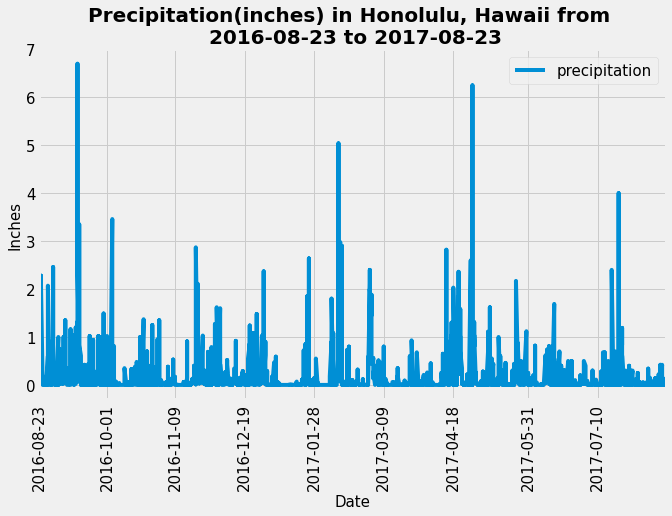

In [65]:
# Use Pandas Plotting with Matplotlib to plot the data. note to myself: doesnt work --> plt.plot(dates, precipitation) not the same first dimension.
plt.figure(figsize=(10, 6))
plt.plot(precipitation.index, precipitation)

# Legend
plt.legend(['precipitation'], loc="upper right", fontsize=15)

# set x location
x_axis = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', 
          '2017-03-09', '2017-04-18','2017-05-31','2017-07-10']

# Assign x-ticks
plt.xticks(x_axis, rotation='vertical',fontsize=15)

# Set Labels & Title
plt.xlabel('Date', fontsize=15)
plt.ylabel("Inches",fontsize=15)
plt.title(f"Precipitation(inches) in Honolulu, Hawaii from \n {query_date} to {last_date}",fontsize=20, fontweight = 'bold')
plt.yticks(size=15)

# Set x and y limits
plt.xlim(0,360)
plt.ylim(-0.3,7)


# Save Figure
plt.savefig("Images/precipitation_plot.png", bbox_inches = 'tight')
# Show plot
plt.show()

In [66]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_sorted_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [67]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [69]:
# # Get a list of column names and types to identify columns
# columns = inspector.get_columns('station')
# for c in columns:
#     print(c['name'], c["type"])

In [70]:
sel = [Station.station, Station.name, Measurement.station, func.count(Measurement.station).label('station_count')]
sel

In [71]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_group_count = session.query(*sel).filter(Station.station == Measurement.station).group_by(Station.station)
station_group_count
final_station_group_count = station_group_count.order_by(func.count(Measurement.station).desc()).all()

for row in final_station_group_count:
    print(f"{row.name} has: \n {row.station_count} {row.station} stations")


WAIHEE 837.5, HI US has: 
 2772 USC00519281 stations
WAIKIKI 717.2, HI US has: 
 2724 USC00519397 stations
KANEOHE 838.1, HI US has: 
 2709 USC00513117 stations
WAIMANALO EXPERIMENTAL FARM, HI US has: 
 2669 USC00519523 stations
MANOA LYON ARBO 785.2, HI US has: 
 2612 USC00516128 stations
KUALOA RANCH HEADQUARTERS 886.9, HI US has: 
 2202 USC00514830 stations
HONOLULU OBSERVATORY 702.2, HI US has: 
 1979 USC00511918 stations
PEARL CITY, HI US has: 
 1372 USC00517948 stations
UPPER WAHIAWA 874.3, HI US has: 
 511 USC00518838 stations


In [72]:
# The most active stations
top_station_group_count = station_group_count.order_by(func.count(Measurement.station).desc()).first()
top_station_group_count
print(f"{top_station_group_count[1]} has the most stations named {top_station_group_count[2]}: {top_station_group_count[3]} stations")

WAIHEE 837.5, HI US has the most stations named USC00519281: 2772 stations


In [73]:
top_station = top_station_group_count[2]
top_station

'USC00519281'

In [76]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

sel1 = [func.min(Measurement.tobs).label('min_temp'), func.max(Measurement.tobs).label('max_temp'), 
        func.avg(Measurement.tobs).label('avg_temp'), Station.name.label('station_name')]

top_station_q = session.query(*sel1).join(Station, Measurement.station==Station.station).\
                    filter(Measurement.station == top_station).first()

print(f'maximum temperature of {top_station_q.station_name} is: {top_station_q.max_temp}')
print(f'minimum temperature of {top_station_q.station_name} is: {top_station_q.min_temp}')
print(f'average temperature of {top_station_q.station_name} is: {top_station_q.avg_temp}')

maximum temperature of WAIHEE 837.5, HI US is: 85.0
minimum temperature of WAIHEE 837.5, HI US is: 54.0
average temperature of WAIHEE 837.5, HI US is: 71.66378066378067


In [78]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

final = session.query(Measurement.tobs).filter(Measurement.date.between(query_date,last_date),\
                   Measurement.station == top_station).all()

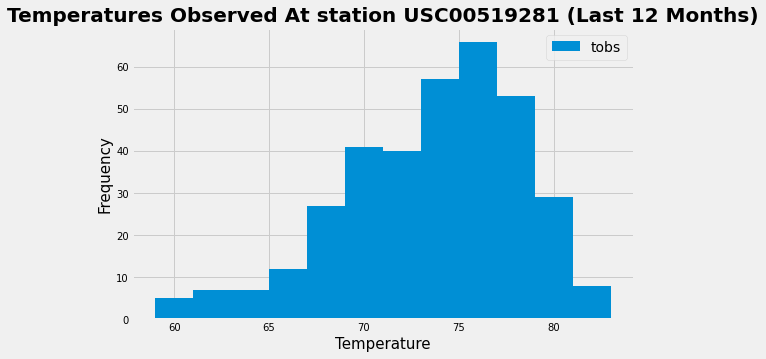

In [79]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram (Cont.)
# Plot the results as a histogram
plt.figure(figsize=(8,5))
plt.hist(np.ravel(final), bins=12)
plt.title('Temperatures Observed At station USC00519281 (Last 12 Months)',fontsize=20, fontweight = 'bold')
plt.xlabel('Temperature',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.legend(['tobs'], loc = 'upper right')
plt.yticks(size=10)
plt.xticks(size=10)

# Save Figure
plt.savefig("Images/station_plot.png")
# Show plot
plt.show()

# Close session

In [80]:
# Close Session
session.close()